In [9]:
import sys 
sys.path.append('../')
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib import ticker
import numpy as np
import torch.nn.functional as F
import scipy
import pandas as pd
import os
import glob
import scienceplots
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.style.use('science')
pd.set_option('display.float_format', lambda x: '%.4e' % x)
# import seaborn as sns
from utils import create_expdf, fetch_subdf
from dataset.generate_dataset_1d import poisson_kernel, logarithm_kernel
from mpl_toolkits.axes_grid1 import make_axes_locatable

from src.model import MLP
from src.dataset import load_mat1d 
from src.utils import rl2_error

In [24]:
# load data
task = 'schrodinger1d'
seed = 4
gn_schrodinger_df = pd.read_csv('../results/schrodinger1d/GN1D-rational-513-50-1.0000-none-{:}/hist.csv'.format(seed))
gnaug2_schrodinger_df = pd.read_csv('../results/schrodinger1d/GN1D-rational-513-50-1.0000-aug2-{:}/hist.csv'.format(seed))
gn_schrodinger_kernel = np.load('../results/schrodinger1d/GN1D-rational-513-50-1.0000-none-{:}/approx_kernel.npy'.format(seed))
gnaug2_schrodinger_kernel = np.load('../results/schrodinger1d/GN1D-rational-513-50-1.0000-aug2-{:}/approx_kernel.npy'.format(seed))

# process green's function
idx = 257
nh = 513
h = 6/(nh-1) # x in [-1, 1]
xh = torch.linspace(-1,1,nh)
x_i = torch.cartesian_prod(xh, xh)
G_gn = gn_schrodinger_kernel.reshape(-1) / h
G_gnaug2 = gnaug2_schrodinger_kernel / h

ntest = 100
F_test = load_mat1d('../dataset/f1d_513_3.00e-02.mat', 'F', ntest, False)
U_test = load_mat1d('../dataset/schrodinger1d_513_3.00e-02.mat', 'U', ntest, False)

U_gnaug = h * G_gnaug2.reshape(nh,nh) @ F_test
U_gn = h * G_gn.reshape(nh,nh) @ F_test

err_diff = []
for i in range(ntest):
    err_gnaug = rl2_error(U_gnaug[:,i], U_test[:,i])
    err_gn = rl2_error(U_gn[:,i], U_test[:,i])
    err_diff.append(err_gnaug - err_gn)
print(np.argmin(err_diff), min(err_diff))

87 -0.001135003649443579


# sample output comparison

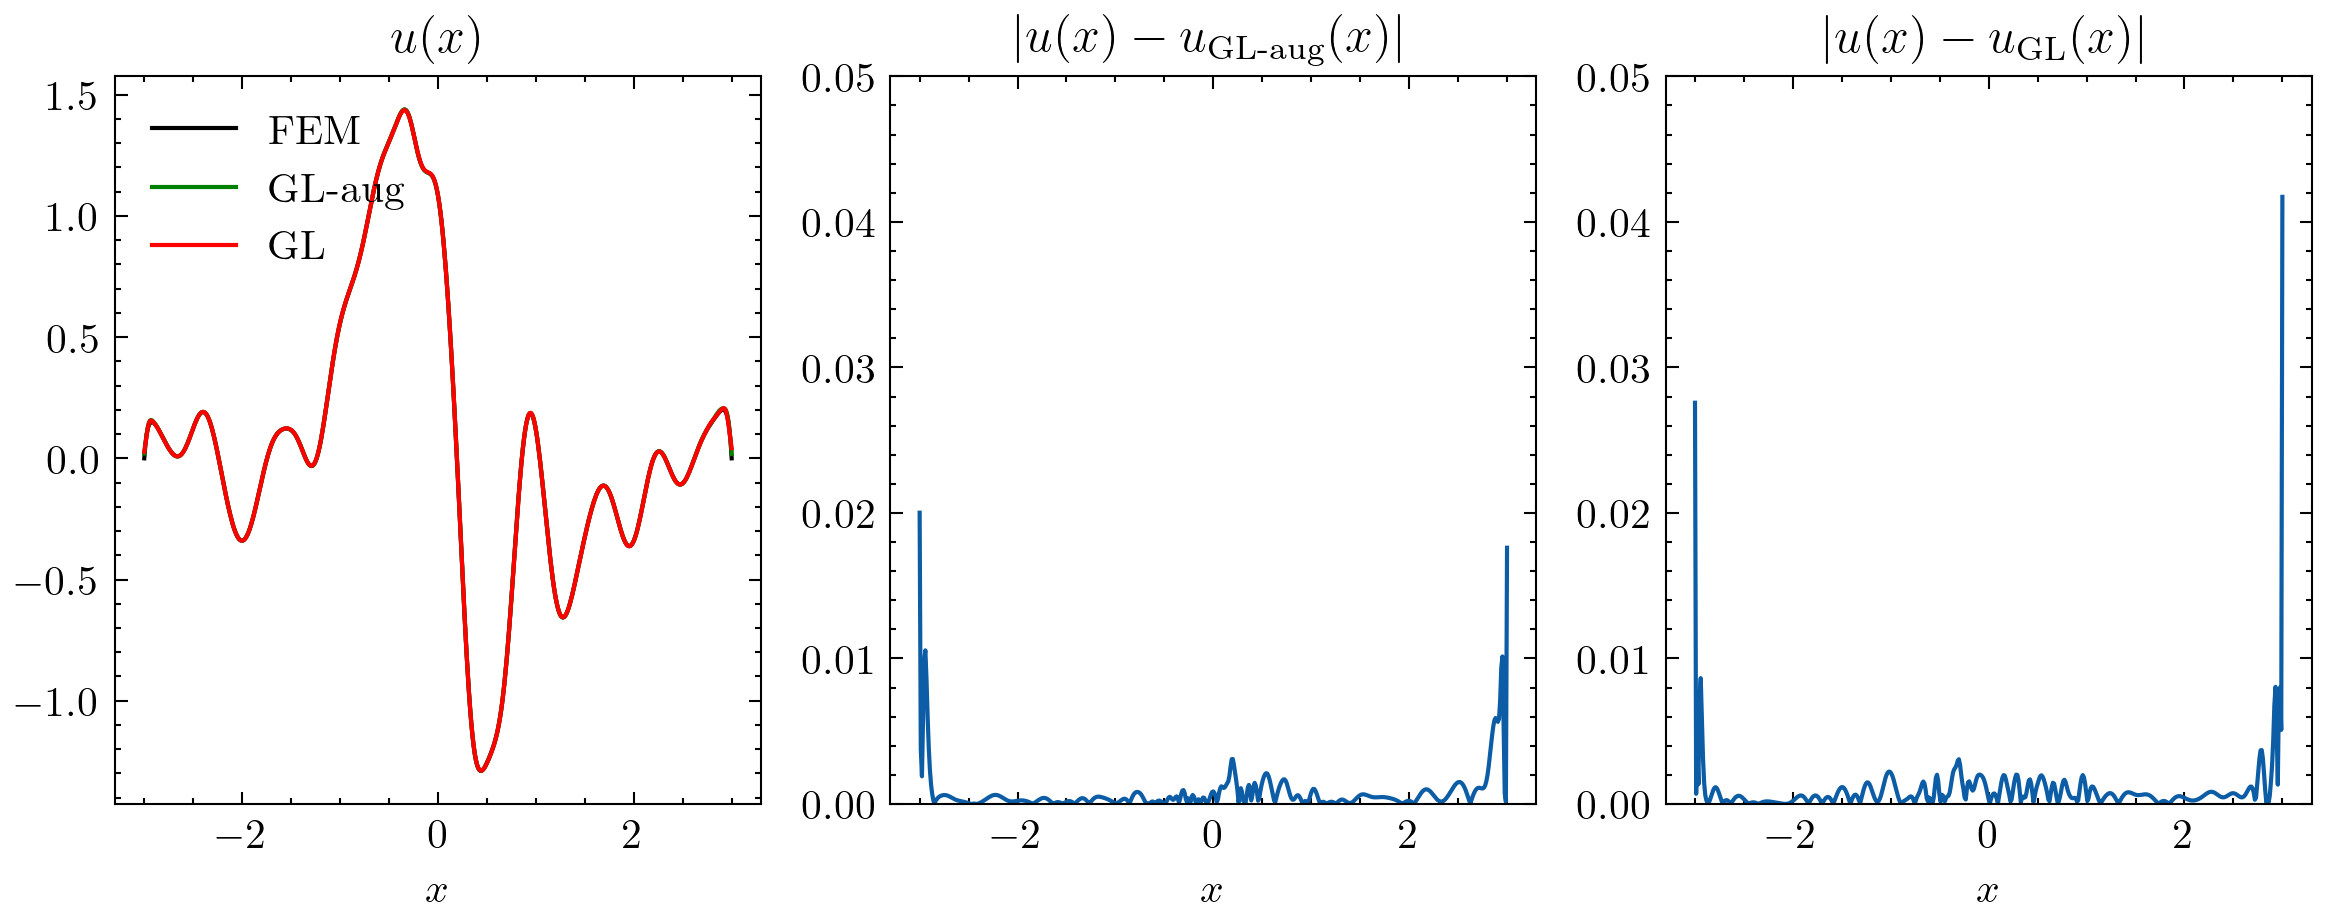

In [25]:
idx = np.argmin(err_diff)

cm = 1/2.54
f = plt.figure(figsize=(24*cm, 8*cm))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

ax1.plot(xh*3, U_test[:,idx], '-k',label='FEM')
ax1.plot(xh*3, U_gnaug[:,idx], '-g',label='GL-aug')
ax1.plot(xh*3, U_gn[:,idx], '-r', label='GL')
ax1.title.set_text('$u(x)$')
ax1.set_xlabel('$x$')
ax1.legend(loc='upper left')

ax2.plot(xh*3, np.abs(U_test[:,idx] - U_gnaug[:,idx]))
ax2.title.set_text('$|u(x)-u_{\\text{GL-aug}}(x)|$')
ax2.set_xlabel('$x$')
ax2.set_ylim([0,5e-2])

ax3.plot(xh*3, np.abs(U_test[:,idx] - U_gn[:,idx]))
ax3.title.set_text('$|u(x)-u_{\\text{GL}}(x)|$')
ax3.set_xlabel('$x$')
ax3.set_ylim([0,5e-2])

outnm = './{:}_usample.png'.format(task)
plt.savefig(outnm)

GL-aug Green's Function

In [26]:
levels = np.linspace(-1.5,10,30)

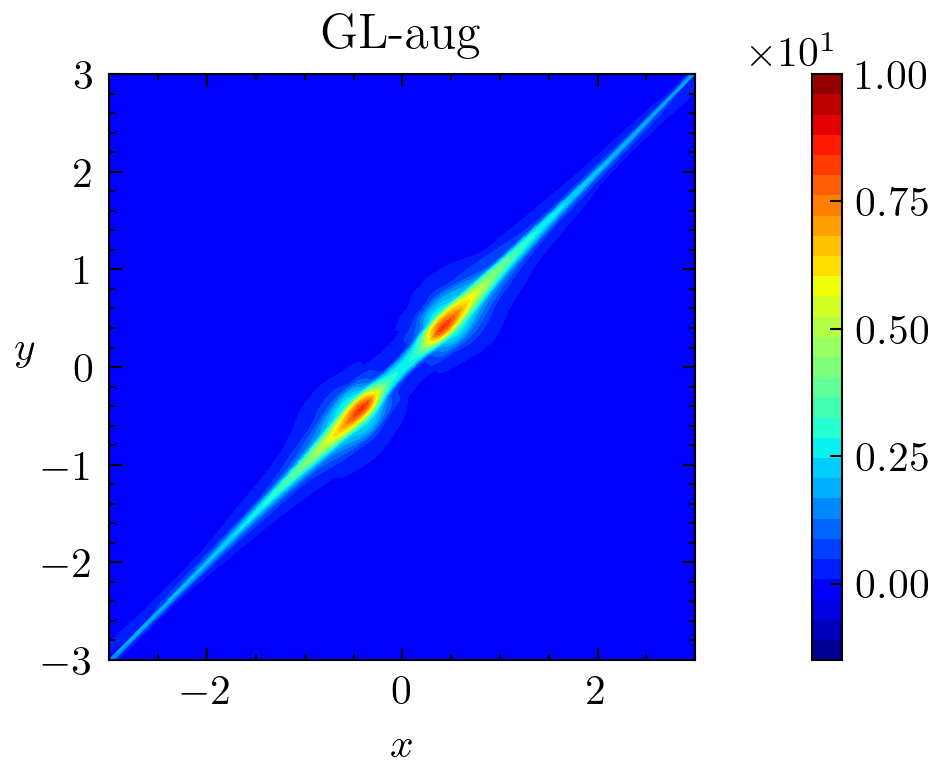

In [27]:
cm = 1/2.54
f = plt.figure(figsize=(8*cm, 8*cm))
ax = f.add_subplot()
im = ax.contourf(
    x_i[:,0].reshape(nh,nh)*3, x_i[:,1].reshape(nh,nh)*3,
    G_gnaug2.reshape(nh,nh), levels=levels, cmap='jet')
ax.set_title('GL-aug')
ax.set_aspect('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$', rotation=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%')#, pad=0.2)
cbar = f.colorbar(im, cax=cax, orientation='vertical')
cbar.locator = ticker.MaxNLocator(nbins=5)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
outnm = './{:}_GL-aug.png'.format(task)
plt.savefig(outnm)

GL Green's Function

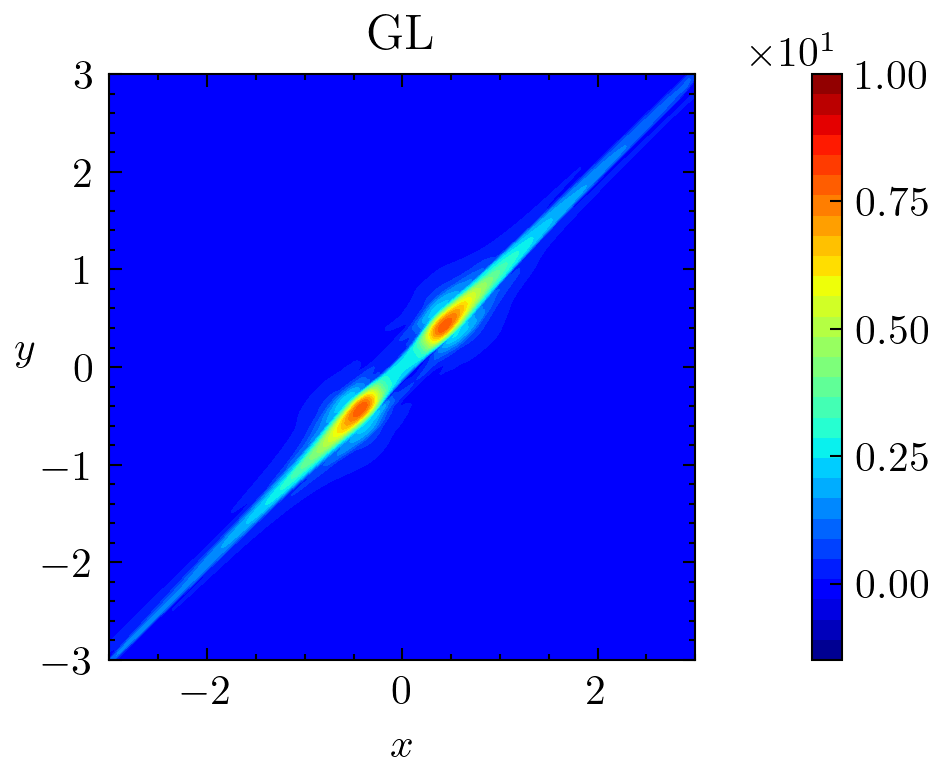

In [28]:
cm = 1/2.54
f = plt.figure(figsize=(8*cm, 8*cm))
ax = f.add_subplot()
im = ax.contourf(
    x_i[:,0].reshape(nh,nh)*3, x_i[:,1].reshape(nh,nh)*3,
    G_gn.reshape(nh,nh), levels=levels, cmap='jet')
ax.set_title('GL')
ax.set_aspect('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$', rotation=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%')#, pad=0.2)
cbar = f.colorbar(im, cax=cax, orientation='vertical')
cbar.locator = ticker.MaxNLocator(nbins=5)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
outnm = './{:}_GL.png'.format(task)
plt.savefig(outnm)